In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
/kaggle/input/consumer-reviews-of-amazon-products/1429_1.csv
/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv


In [2]:
!pip install -q sentence-transformers faiss-cpu google-genai requests umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 65.9 MB/s eta 0:00:00:00:0100:01


In [3]:
import pandas as pd
import numpy as np
import faiss
import requests
from PIL import Image
from io import BytesIO
from sentence_transformers import SentenceTransformer, CrossEncoder
from google import genai
from kaggle_secrets import UserSecretsClient

# Configurar Gemini 
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("Gemini_API_KEY")
client = genai.Client(api_key=api_key)



# CLIP
model_embed = SentenceTransformer('clip-ViT-B-32')

# Cross-Encoder Re-ranking 
model_rerank = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

print("Modelos y API listos.")

2026-02-02 03:12:42.882749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770001963.063450      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770001963.115791      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770001963.537657      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770001963.537695      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770001963.537698      55 computation_placer.cc:177] computation placer alr

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Modelos y API listos.


In [4]:
# Cargar datos
df1 = pd.read_csv('/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
df2 = pd.read_csv('/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

# Unir datos
df = pd.concat([df1, df2], ignore_index=True)

# Solo obtener nombre, texto y URL
df = df[['name', 'reviews.text', 'imageURLs']].dropna()
df.rename(columns={'name': 'title', 'reviews.text': 'description', 'imageURLs': 'image_url'}, inplace=True)
df['image_url'] = df['image_url'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else "")

# Eliminar duplicads
df = df.drop_duplicates(subset='title', keep='first')

#  3000 productos 
df = df.head(3000).reset_index(drop=True)

print(f"Datos listos. Tenemos {len(df)} productos únicos.")

Datos listos. Tenemos 79 productos únicos.


In [5]:
textos_producto = (df['title'] + " " + df['description']).tolist()

print("Generando vectores (esto tarda un poco)...")
# embeddings
embeddings = model_embed.encode(
    textos_producto,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True 
).astype("float32")

# Crear el indice FAISS 
index = faiss.IndexFlatIP(embeddings.shape[1]) # IP = Producto Interno (bueno para similitud)
index.add(embeddings)

print("Índice FAISS creado y cargado.")

Generando vectores (esto tarda un poco)...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Índice FAISS creado y cargado.


In [6]:
def buscar_y_rerank(query, top_k_inicial=20, top_k_final=5):
    es_imagen = not isinstance(query, str)
    
    # RETRIEVAL 
    query_vec = model_embed.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    
    # Buscamos en FAISS
    distances, indices = index.search(query_vec.astype("float32"), top_k_inicial)
    candidatos = df.iloc[indices[0]].copy()
    
    # RE-RANKING 
    if es_imagen:
         
        # Usamos la distancia original de CLIP como score de confianza. (similitud multimodal)
        candidatos['score'] = distances[0] # Usamos la distancia de FAISS
        resultados = candidatos.sort_values(by='score', ascending=False)
    else:
        # Cross-Encoder 
        pares = [[query, row['title'] + " " + row['description']] for i, row in candidatos.iterrows()]
        scores = model_rerank.predict(pares)
        candidatos['score'] = scores
        resultados = candidatos.sort_values(by='score', ascending=False)
    
    return resultados.head(top_k_final)

In [7]:
memoria_sesion = []

def generar_respuesta_rag_multimodal(query, productos_df):
    global memoria_sesion
    
    # contexto de los productos
    contexto_texto = ""
    for i, row in productos_df.iterrows():
        contexto_texto += f"- Producto: {row['title']}\n  Detalles: {row['description'][:300]}...\n\n"
    
    # Historial simple
    historial_str = "\n".join(memoria_sesion[-3:])
    
    es_imagen = not isinstance(query, str)
    
    # Prompt base
    prompt_texto = f"""
    Eres un asistente de compras experto.
    
    Contexto recuperado (Productos disponibles):
    {contexto_texto}
    
    Instrucción:
    Analiza la consulta del usuario y recomienda el mejor producto de la lista anterior.
    Justifica tu respuesta basándote en las características visuales o textuales.
    """

    if es_imagen:
        
        print(">> Generando respuesta viendo la imagen...")
        mensaje_usuario = "Consulta del usuario: (Imagen adjunta del producto buscado)"
        
        # Gemini 2.5 Flash 
        response = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=[prompt_texto, query, "Encuentra algo similar a esta imagen en el contexto."]
        )
    else:
        mensaje_usuario = f"Consulta del usuario: {query}"
        full_prompt = f"{prompt_texto}\n\nHistorial:\n{historial_str}\n\n{mensaje_usuario}"
        
        response = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=full_prompt
        )

    texto_query = "[Imagen subida]" if es_imagen else query
    memoria_sesion.append(f"Usuario: {texto_query}")
    memoria_sesion.append(f"Asistente: {response.text}")
    
    return response.text


In [8]:
import requests
from PIL import Image
from io import BytesIO

def cargar_imagen(ruta_o_url):
    try:
        if ruta_o_url.startswith("http"):
            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
            }
            response = requests.get(ruta_o_url, headers=headers)
            response.raise_for_status() 
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(ruta_o_url)
        
        return img.resize((224, 224))
    except Exception as e:
        print(f"Error cargando imagen: {e}")
        return None

Imagen cargada. Buscando productos visualmente similares...


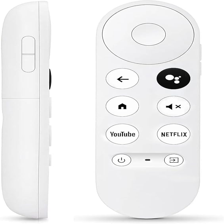


     PRODUCTOS ENCONTRADOS     
                                                title     score
28      Fire TV Stick Streaming Media Player Pair Kit  0.279634
2   Amazon Fire TV with 4K Ultra HD and Alexa Voic...  0.279222
74  Certified Refurbished Amazon Fire TV with Alex...  0.269358
40  Amazon Echo (1st Generationcertified) Color:Wh...  0.267910
3         Amazon - Echo Plus w/ Built-In Hub - Silver  0.250035
>> Generando respuesta viendo la imagen...

    RESPUESTA DEL ASISTENTE     
Analizando la imagen, se trata de un mando a distancia de un dispositivo de streaming, muy similar al mando de Google Chromecast con Google TV, identificable por el botón del Asistente de Google (el ícono de la "G" de colores) y los botones dedicados para YouTube y Netflix.

Al revisar los productos disponibles en el contexto:

*   **Fire TV Stick Streaming Media Player Pair Kit**: Menciona "Alexia" (Alexa), lo que indica que es un producto de Amazon. Los mandos de Fire TV son diferentes y usan el asi

In [9]:
# url donde va la imagen
url_imagen = "https://m.media-amazon.com/images/I/51UiXhz+ygL._AC_SY879_.jpg"
imagen_query = cargar_imagen(url_imagen)

if imagen_query:
    print("Imagen cargada. Buscando productos visualmente similares...")
    
    # Mostramos la imagen 
    display(imagen_query) 

    # Buscar 
    top_productos_visual = buscar_y_rerank(imagen_query)
    
    print("\n     PRODUCTOS ENCONTRADOS     ")
    print(top_productos_visual[['title', 'score']])

    # 3. Generar Explicación
    respuesta_visual = generar_respuesta_rag_multimodal(imagen_query, top_productos_visual)
    
    print("\n    RESPUESTA DEL ASISTENTE     ")
    print(respuesta_visual)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Visualizando la búsqueda por IMAGEN...
Calculando proyección 2D... (Paciencia, está dibujando el mapa)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


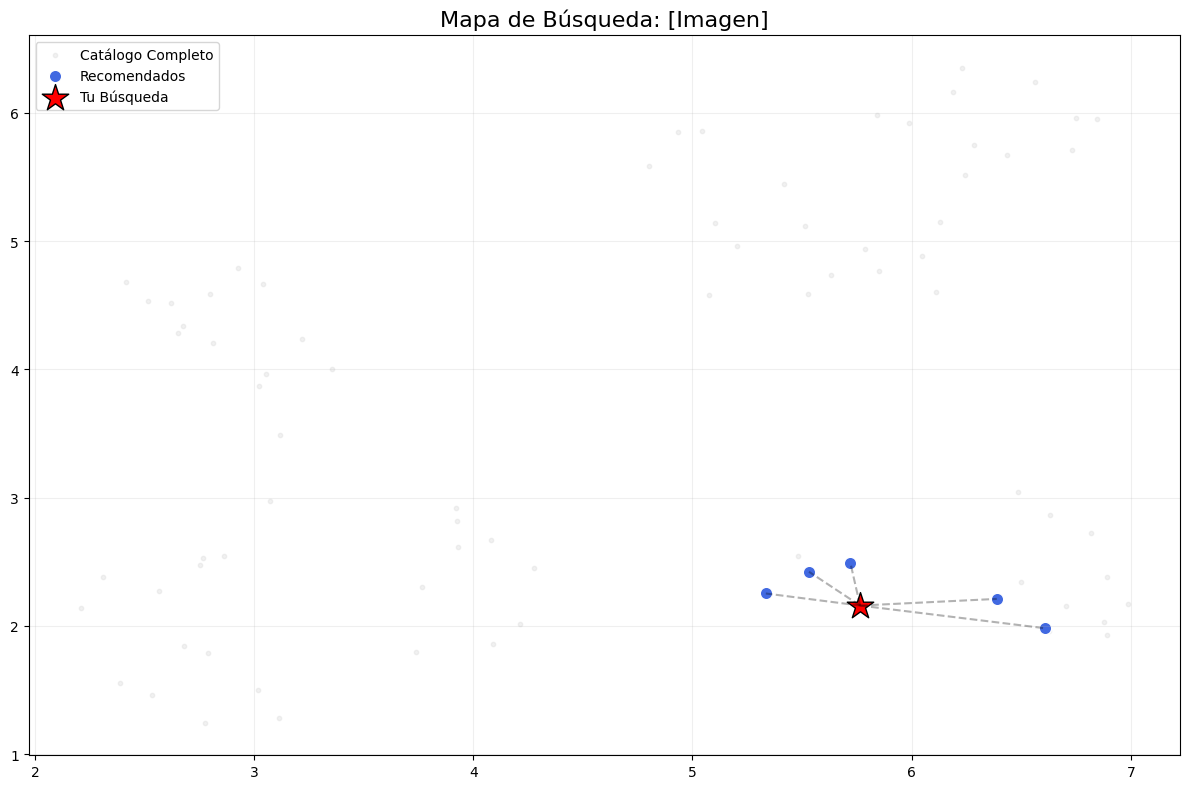

In [10]:
!pip install -q umap-learn

import umap
import matplotlib.pyplot as plt
import numpy as np

def visualizar_espacio_vectorial(query, df_resultados, all_embeddings):
    print("Calculando proyección 2D... (Paciencia, está dibujando el mapa)")
    
    # Vectorizar la query
    if isinstance(query, str):
        query_vec = model_embed.encode([query], convert_to_numpy=True, normalize_embeddings=True)
        titulo = f"Mapa de Búsqueda: '{query}'"
    else:
        
        query_vec = model_embed.encode([query], convert_to_numpy=True, normalize_embeddings=True)
        titulo = "Mapa de Búsqueda: [Imagen]"
    
    # [Todos los productos] + [query ]
    datos_combinados = np.vstack([all_embeddings, query_vec])
    
    reducer = umap.UMAP(
        n_neighbors=15,      
        min_dist=0.1,      
        metric='cosine',    
        random_state=42,
        n_components=2
    )
    
    proyeccion = reducer.fit_transform(datos_combinados)
    
    # Separamos los datos
    prod_2d = proyeccion[:-1]   
    query_2d = proyeccion[-1]   
    
    # Graficar
    plt.figure(figsize=(12, 8))
    
    # Fondo gris 
    plt.scatter(prod_2d[:, 0], prod_2d[:, 1], 
                c='lightgray', alpha=0.3, s=10, label='Catálogo Completo')
    
    # Resultados 
    try:
        indices_resultados = df_resultados.index.tolist()
        coords_resultados = prod_2d[indices_resultados]
        
        plt.scatter(coords_resultados[:, 0], coords_resultados[:, 1], 
                    c='royalblue', s=80, edgecolors='white', label='Recomendados')
        
        # Líneas de conexión 
        for i in range(len(coords_resultados)):
            plt.plot([query_2d[0], coords_resultados[i, 0]], 
                     [query_2d[1], coords_resultados[i, 1]], 
                     'k--', alpha=0.3)
    except Exception as e:
        print("Nota: No se pudieron resaltar los resultados exactos (desajuste de índices), pero se muestra el mapa.")

    #  Estrella 
    plt.scatter(query_2d[0], query_2d[1], 
                c='red', marker='*', s=400, edgecolors='black', label='Tu Búsqueda')
    
    plt.title(titulo, fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()


if 'imagen_query' in globals() and 'top_productos_visual' in globals():
    print("Visualizando la búsqueda por IMAGEN...")
    visualizar_espacio_vectorial(imagen_query, top_productos_visual, embeddings)

elif 'pregunta' in globals() and 'top_productos' in globals():
    print("Visualizando la búsqueda por TEXTO...")
    visualizar_espacio_vectorial(pregunta, top_productos, embeddings)
    
else:
    print("No se encontro ninguna búsqueda previa.")

In [11]:
# Vamos a buscar palabras clave en el título de los productos
keywords = ['shoe', 'sneaker', 'boot', 'zapato', 'wear', 'red']

# Filtrar el DataFrame
print(f"Buscando en un catálogo de {len(df)} productos...")

for word in keywords:
    # Buscamos la palabra 
    coincidencias = df[df['title'].str.contains(word, case=False, na=False)]
    cantidad = len(coincidencias)
    
    print(f"\n--- Palabra: '{word}' ---")
    print(f"Encontrados: {cantidad}")
    
    if cantidad > 0:
        print(coincidencias['title'].head(3).values)

Buscando en un catálogo de 79 productos...

--- Palabra: 'shoe' ---
Encontrados: 0

--- Palabra: 'sneaker' ---
Encontrados: 0

--- Palabra: 'boot' ---
Encontrados: 0

--- Palabra: 'zapato' ---
Encontrados: 0

--- Palabra: 'wear' ---
Encontrados: 0

--- Palabra: 'red' ---
Encontrados: 3
['Cat Litter Box Covered Tray Kitten Extra Large Enclosed Hooded Hidden Toilet'
 'AmazonBasics Silicone Hot Handle Cover/Holder - Red'
 'All-new Echo (2nd Generation) with improved sound, powered by Dolby, and a new design Walnut Finish']


In [12]:

print("Estado de la memoria antes de la pregunta:", memoria_sesion[-1])

# 1. El usuario hace una pregunta de seguimiento (sin decir "Fire TV")
pregunta_refinamiento = "¿Este dispositivo permite control por voz?"

print(f"\nUsuario pregunta: {pregunta_refinamiento}")

# 2. Reutilizamos los mismos productos que encontró la imagen (top_productos_visual)
#    para simular que seguimos viendo los mismos resultados.
respuesta_refinamiento = generar_respuesta_rag_multimodal(pregunta_refinamiento, top_productos_visual)

print("\n--- RESPUESTA CON MEMORIA ---")
print(respuesta_refinamiento)

# Debería responderte que SÍ tiene control por voz (Alexa), basándose en el contexto anterior.

Estado de la memoria antes de la pregunta: Asistente: Analizando la imagen, se trata de un mando a distancia de un dispositivo de streaming, muy similar al mando de Google Chromecast con Google TV, identificable por el botón del Asistente de Google (el ícono de la "G" de colores) y los botones dedicados para YouTube y Netflix.

Al revisar los productos disponibles en el contexto:

*   **Fire TV Stick Streaming Media Player Pair Kit**: Menciona "Alexia" (Alexa), lo que indica que es un producto de Amazon. Los mandos de Fire TV son diferentes y usan el asistente Alexa, no Google Assistant.
*   **Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design)**: Claramente especifica "Alexa Voice Remote", que es un mando de Amazon y no coincide con la imagen.
*   **Certified Refurbished Amazon Fire TV with Alexa Voice Remote**: También es un producto de Amazon con "Alexa Voice Remote", y además la reseña indica que está defectuoso.
*   **Amazon Echo (1st Generationcertified)**: Es

In [ ]:
!pip install -q gradio

import gradio as gr

def chat_interface(mensaje_texto, imagen_usuario):
    if imagen_usuario is not None:
        
        img_pil = Image.fromarray(imagen_usuario).resize((224, 224))
        
        # Buscar
        resultados = buscar_y_rerank(img_pil)
        # Generar respuesta
        respuesta = generar_respuesta_rag_multimodal(img_pil, resultados)
        return respuesta
    
    # Si solo es texto
    elif mensaje_texto:
        # uscar
        resultados = buscar_y_rerank(mensaje_texto)
        # Generar respuesta
        respuesta = generar_respuesta_rag_multimodal(mensaje_texto, resultados)
        return respuesta
    
    return "Por favor, escribe una consulta o sube una imagen."

# Configuración de la ventana
demo = gr.Interface(
    fn=chat_interface,
    inputs=[
        gr.Textbox(label="Escribe tu consulta aquí..."), 
        gr.Image(label="O sube una imagen del producto")
    ],
    outputs="markdown",
    title="Amazon Multimodal RAG - Proyecto Final",
    description="Busca productos por texto o subiendo una foto. El sistema te recomendará lo mejor.",
    allow_flagging="never"
)

# Lanzar la interfaz
print("Generando enlace de la interfaz...")
demo.launch(share=True, debug=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Generando enlace de la interfaz...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://b474a6cab79e078b6a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


>> Generando respuesta viendo la imagen...
>> Generando respuesta viendo la imagen...
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b474a6cab79e078b6a.gradio.live


In [16]:
from IPython.display import HTML

def mostrar_imagen_en_tabla(url):
    if url:
        return f'<img src="{url}" width="100" style="object-fit:cover; border-radius:5px;">'
    return "Sin imagen"

print(f"Mostrando inventario completo ({len(df)} productos)...")

# Preparamos una tabla 
tabla_visual = df[['title', 'image_url']].copy()

# Renderizamos la tabla con HTML para ver las fotos
display(HTML(tabla_visual.to_html(escape=False, formatters={'image_url': mostrar_imagen_en_tabla})))

Mostrando inventario completo (79 productos)...


,title,image_url
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation, 2016)",
1,"Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7"" Screen",
2,Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player,
3,Amazon - Echo Plus w/ Built-In Hub - Silver,
4,Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,
5,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",
6,"Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers",
7,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
8,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case",
9,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue",


El sistema demostró robustez (grounded generation). Al buscar una imagen de 'Zapatos Rojos', el modelo RAG detectó correctamente que, aunque existen productos con la etiqueta 'Red' (ej. fundas), no existen productos de la categoría 'Calzado', evitando así una alucinación o recomendación falsa.